In [1]:
using Gen
using Plots
using Logging
Logging.disable_logging(Logging.Info)

LogLevel(1)

# Tracking Fireflies


## Tracking by Detection
In computer vision, one of the most popular methods for tracking objects is called "Tracking-by-Detection". In a first pass, you use an object detector to identify all the objects of interest in a scene. Next, you apply some dynamics update to your detected objects (typically some kind of linear filter, like a Kalman Filter). 

This tracking-by-detection method can be brittle when there's lots of occlusion, and you don't have reliable detection. 

## What happens when there's not much detection?

Let's imagine it's a summer evening. You're sitting on a porch, and see a small glow in the distance. It's a firefly! If you want to catch the firefly, you'll observe a blink, make some movements, and wait for another blink. We don't just get rid of a track if we don't detect anything. Fireflies are an excellent use case for investigating how humans track under uncertainty. When do we give up on a track? When do we wait for more information? 

## Probabilistic Generative Model

Cognitive Science has a rich tradition of studying human behavior with probabilistic generative models. Here, we'll see if we can capture human behavior with a generative model of mock firefly behavior.

In [2]:
# Define firefly observation model
@gen function single_firefly(scene_size::Int, steps::Int)
    # sample number of fireflies
    xs = zeros(steps)
    ys = zeros(steps)
    vxs = zeros(steps)
    vys = zeros(steps) 
    blinking = zeros(steps)

    # We'll assign the firefly a blinking frequency
    blink_freq = {:freq} ~ normal(0.25, 0.05)

    for t in 1:steps
        if t == 1
            # We'll initialize the position uniformly in our grid
            xs[t] = {(:x, t)} ~ uniform_discrete(1, scene_size - 1)
            ys[t] = {(:y, t)} ~ uniform_discrete(1, scene_size - 1)

            # We can assign a uniform discrete velocity to the firefly as well
            vxs[t] = {(:vx, t)} ~ uniform_discrete(-1, 1)
            vys[t] = {(:vy, t)} ~ uniform_discrete(-1, 1)
        else
            prev_x = xs[t - 1]
            prev_y = ys[t - 1]

            vx = vxs[t - 1]
            vy = vys[t - 1]

            # Keep the firefly in the scene bounds
            if prev_x + vx < 0 || prev_x + vx > scene_size 
                vx = -vx
            end
            if prev_y + vy < 0 || prev_y + vy > scene_size 
                vy = -vy
            end
            
            xs[t] = {(:x, t)} ~ normal(prev_x + vx, 0.05)
            ys[t] = {(:y, t)} ~ normal(prev_y + vy, 0.05)
            vxs[t] = {(:vx, t)} ~ uniform_discrete(-1, 1)
            vys[t] = {(:vy, t)} ~ uniform_discrete(-1, 1)
        end

        blinking[t] = {(:blinking, t)} ~ bernoulli(blink_freq)
    end
    
    return Dict("xs" => xs, "ys" => ys, "blink_freq" => blink_freq, "blinking" => blinking)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##single_firefly#312", Bool[0, 0], false)

In [3]:
function visualize_trace(tr)
    plot()
    scene_size, steps = get_args(tr)
    retval = get_retval(tr)
    xs = retval["xs"]
    ys = retval["ys"]
    choices = get_choices(tr)
    blink_freq = 0.25 #choices[:freq]

    anim = Plots.@animate for i in 1:steps
        fig = plot(layout = grid(1,2), legend=false, size=(800, 400))
        if i > 1
            plot!(fig[1], xs[1:i], ys[1:i], color=colormap("Blues", i), markersize=2, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size), title="Actual Location (T=$i)")
        end
        
        blinking = Int(choices[(:blinking, i)])
        if blinking == 1
            scatter!(fig[2], [xs[i]], [ys[i]], color="yellow", markersize=10, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size), title="Observed Location (T=$i)") 
            scatter!(fig[1], [xs[i]], [ys[i]], color="yellow", markersize=10, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size)) 
        else
            scatter!(fig[2], [], [], label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size), title="Observed Location (T=$i)")
            scatter!(fig[1], [xs[i]], [ys[i]], markercolor=RGBA(1, 1, 1, 0), markersize=10, label=nothing, 
            xlim=(0, scene_size), ylim=(0, scene_size)) 
        end

        xlims!(0, scene_size)
        ylims!(0, scene_size)
    end
    return anim
end


visualize_trace (generic function with 1 method)

Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/tmp.gif")
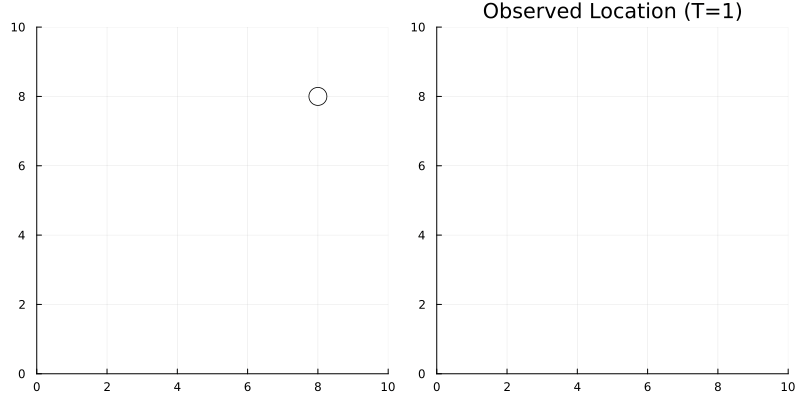

In [4]:
scene_size = 10
steps = 50
actual_trace = simulate(single_firefly, (scene_size, steps))
gif(visualize_trace(actual_trace), fps=5)


In [5]:
function make_constraints(trace)
    constraints = choicemap()
    choices = get_choices(trace)
    scene_size, t = get_args(trace)

    for i in 1:t
        x = choices[(:x, i)]
        y = choices[(:y, i)]
        blinking = choices[(:blinking, i)]
        if Int(blinking) == 1 
            constraints[(:x, i)] = x
            constraints[(:y, i)] = y
            constraints[(:blinking, i)] = blinking
        else
            constraints[(:blinking, i)] = 0
        end
    end
    return constraints
end

make_constraints (generic function with 1 method)

In [6]:
constraints = make_constraints(actual_trace)

│
├── (:blinking, 4) : true
│
├── (:blinking, 10) : 0
│
├── (:blinking, 36) : 0
│
├── (:blinking, 1) : 0
│
├── (:y, 16) : 7.244899399021689
│
├── (:x, 26) : 8.664833047408683
│
├── (:blinking, 27) : 0
│
├── (:x, 48) : 7.865660761281689
│
├── (:blinking, 12) : 0
│
├── (:blinking, 33) : 0
│
├── (:blinking, 2) : 0
│
├── (:blinking, 44) : 0
│
├── (:x, 19) : 8.897932455232588
│
├── (:blinking, 37) : 0
│
├── (:x, 49) : 6.838768867304886
│
├── (:blinking, 7) : 0
│
├── (:blinking, 30) : 0
│
├── (:blinking, 16) : true
│
├── (:blinking, 22) : 0
│
├── (:blinking, 21) : 0
│
├── (:blinking, 31) : 0
│
├── (:blinking, 39) : 0
│
├── (:blinking, 45) : 0
│
├── (:x, 4) : 8.96551335598699
│
├── (:blinking, 5) : 0
│
├── (:blinking, 8) : 0
│
├── (:blinking, 35) : 0
│
├── (:x, 15) : 9.136281324332744
│
├── (:blinking, 24) : true
│
├── (:blinking, 20) : 0
│
├── (:blinking, 25) : 0
│
├── (:blinking, 17) : 0
│
├── (:blinking, 46) : 0
│
├── (:blinking, 43) : 0
│
├── (:blinking, 40) : 0
│
├── (:blinking, 48) : tr

In [7]:
tr, w = generate(single_firefly, (scene_size, steps), constraints)
println(w)

-17420.161830854955


In [8]:
compute_steps = 10000
(trace, w) = Gen.importance_resampling(single_firefly, (scene_size, steps,), constraints, compute_steps);

In [9]:
w

-1848.8861878535943

Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/tmp.gif")
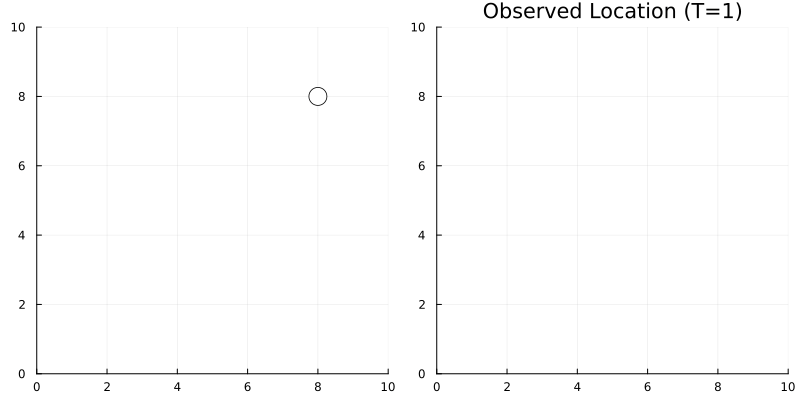

In [10]:
gif(visualize_trace(trace), fps=5)

In [11]:
function get_observation(constraints::ChoiceMap, t::Int)
    obs = choicemap()

    if Gen.has_value(constraints, (:x, t))
        obs[(:x, t)] = constraints[(:x, t)]
        obs[(:y, t)] = constraints[(:y, t)]
        obs[(:blinking, t)] = constraints[(:blinking, t)]
    else
        obs[(:blinking, t)] = 0
    end
    return obs
end

function particle_filter_no_resampling(num_steps::Int, scene_size::Int, num_particles::Int, constraints::ChoiceMap, num_samples::Int)
    
    init_obs = get_observation(constraints, 1)
    state = Gen.initialize_particle_filter(single_firefly, (num_steps, scene_size,), init_obs, num_particles)

    # steps
    for t=2:num_steps
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = get_observation(constraints, t)
        Gen.particle_filter_step!(state, (num_steps, scene_size,), (UnknownChange(),), obs)
    end

    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;


## Exact Inference

Let's try to get a version of this working as exact inference. First, we'll need to discretize everything, so let's construct a slightly simpler version of the generative model:

In [35]:
# Define firefly observation model
@gen function simple_discrete_firefly(scene_size::Int, steps::Int)
    # sample number of fireflies
    xs = zeros(Int, steps)
    ys = zeros(Int, steps)
    vxs = zeros(Int, steps)
    vys = zeros(Int, steps)
    blinking = zeros(Int, steps)

    # Fix a blinking frequency
    blink_freq = 0.25

    for t in 1:steps
        # Update motion
        if t == 1
            # We'll initialize the position uniformly in our grid
            xs[t] = {(:x, t)} ~ uniform_discrete(0, scene_size)
            ys[t] = {(:y, t)} ~ uniform_discrete(0, scene_size)
            # # We can assign a uniform discrete velocity to the firefly as well
            # vxs[t] = {(:vx, t)} ~ uniform_discrete(-1, 1)
            # vys[t] = {(:vy, t)} ~ uniform_discrete(-1, 1)

        else
            prev_x = xs[t - 1]
            prev_y = ys[t - 1]
            # vx = vxs[t - 1]
            # vy = vys[t - 1]
            # # Keep the firefly in the scene bounds
            # if prev_x + vx < 0 || prev_x + vx > scene_size 
            #     vx = -vx
            # end
            # if prev_y + vy < 0 || prev_y + vy > scene_size 
            #     vy = -vy
            # end
            
            xs[t] = {(:x, t)} ~ uniform_discrete(max(0, prev_x - 1), min(scene_size, prev_x + 1))
            ys[t] = {(:y, t)} ~ uniform_discrete(max(0, prev_y - 1), min(scene_size, prev_y + 1))

            # update velocity
            # vxs[t] = {(:vx, t)} ~ uniform_discrete(-1, 1)
            # vys[t] = {(:vy, t)} ~ uniform_discrete(-1, 1)
        end

        # Update blinking
        blinking[t] = {(:blinking, t)} ~ bernoulli(blink_freq)
    end
    
    return Dict("xs" => xs, "ys" => ys, "blink_freq" => blink_freq, "blinking" => blinking)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##simple_discrete_firefly#539", Bool[0, 0], false)

In [36]:
function get_observations(trace::Trace, steps::Int)
    obs = choicemap()
    choices = get_choices(trace)
    for i in 1:steps
        blinking = choices[(:blinking, i)]
        obs[(:blinking, i)] = blinking
        if blinking == true
            obs[(:x, i)] = choices[(:x, i)]
            obs[(:y, i)] = choices[(:y, i)]
        end
    end
    return obs
end

get_observations (generic function with 1 method)

Plots.AnimatedGif("/Users/yonifriedman/Research/ProbComp/Fireflies/tmp.gif")
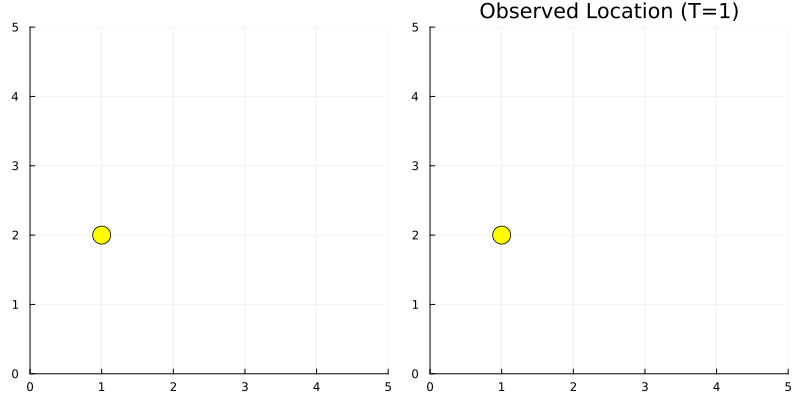

In [38]:
scene_size = 5
steps = 10
actual_trace = simulate(simple_discrete_firefly, (scene_size, steps))
gif(visualize_trace(actual_trace), fps=5)

Now let's write a loop to go through every possible state

In [39]:
observations = get_observations(actual_trace, steps)

│
├── (:blinking, 4) : false
│
├── (:blinking, 10) : true
│
├── (:x, 9) : 0
│
├── (:x, 10) : 0
│
├── (:blinking, 1) : true
│
├── (:blinking, 7) : false
│
├── (:y, 1) : 2
│
├── (:blinking, 9) : true
│
├── (:blinking, 5) : true
│
├── (:blinking, 8) : false
│
├── (:x, 5) : 1
│
├── (:y, 5) : 4
│
├── (:blinking, 6) : false
│
├── (:y, 10) : 3
│
├── (:blinking, 2) : false
│
├── (:x, 1) : 1
│
├── (:blinking, 3) : false
│
└── (:y, 9) : 4


In [44]:

function check_valid_pos(pos, scene_size)
    if pos >= 0 && pos <= scene_size
        return true
    else 
        return false
    end
end

function enumerate_next_steps(x, y, scene_size)
    # breadth first search over all possible traces over a 10 step scene
    new_positions = []
    for vx in -1 : 1
        for vy in -1 : 1
            new_x = x + vx
            new_y = y + vy
            if check_valid_pos(new_x, scene_size) && check_valid_pos(new_y, scene_size)
                push!(new_positions, (new_x, new_y))
            end
        end
    end
    return new_positions
end

function exact_inference(observations, scene_size, steps)
    traces_by_time = [[] for _ in 1:steps]

    # Initialize trace to observation, otherwise enumerate possible starting positions
    if observations[(:blinking, 1)] == true
        init_trace = traces_by_time[1]
        chm = choicemap()
        chm[(:x, 1)] = observations[(:x, 1)]
        chm[(:y, 1)] = observations[(:y, 1)]
        chm[(:blinking, 1)] = true
        trace, _ = generate(simple_discrete_firefly, (scene_size, 1), chm)
        push!(init_trace, trace)
    else
        for start_x in 1:scene_size
            for start_y in 1:scene_size
                for blinking in [true, false]
                    init_traces = traces_by_time[1]
                    chm = choicemap()
                    chm[(:x, 1)] = start_x
                    chm[(:y, 1)] = start_y
                    chm[(:blinking, 1)] = false
                    trace, _ = generate(simple_discrete_firefly, (scene_size, 1), chm)
                    push!(init_traces, trace)
                end
            end
        end
    end

    # Constrain observation or enumerate possible next steps
    for t in 2:steps
        prev_traces = traces_by_time[t - 1]
        current_traces = traces_by_time[t]
        for prev_trace in prev_traces
            x = prev_trace[(:x, t - 1)]
            y = prev_trace[(:y, t - 1)]
            if observations[(:blinking, t)] == true
                chm = choicemap()
                chm[(:x, t)] = observations[(:x, t)]
                chm[(:y, t)] = observations[(:y, t)]
                chm[(:blinking, t)] = true
                new_trace, _ = update(prev_trace, (scene_size, t), (Gen.NoChange(), Gen.UnknownChange()), chm)
                if get_score(new_trace) > -Inf
                    push!(current_traces, new_trace)
                end
            else
                next_possible_steps = enumerate_next_steps(x, y, scene_size)
                for (new_x, new_y) in next_possible_steps
                    new_constraints = choicemap()
                    new_constraints[(:x, t)] = new_x
                    new_constraints[(:y, t)] = new_y
                    new_constraints[(:blinking, t)] = false
                    new_trace, _ = update(prev_trace, (scene_size, t), (Gen.NoChange(), Gen.UnknownChange()), new_constraints)
                    if get_score(new_trace) > -Inf
                        push!(current_traces, new_trace)
                    end
                end
            end
        end
    end

    return traces_by_time
end;

trace_ts = exact_inference(observations, 5, 10)


10-element Vector{Vector{Any}}:
 [Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##simple_discrete_firefly#539", Bool[0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:x, 1) => Gen.ChoiceOrCallRecord{Int64}(1, -1.791759469228055, NaN, true), (:blinking, 1) => Gen.ChoiceOrCallRecord{Bool}(true, -1.3862943611198906, NaN, true), (:y, 1) => Gen.ChoiceOrCallRecord{Int64}(2, -1.791759469228055, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -4.969813299576001, 0.0, (5, 1), Dict{String, Any}("blink_freq" => 0.25, "blinking" => [1], "xs" => [1], "ys" => [2]))]
 [Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##simple_discrete_firefly#539", Bool[0, 0], false), Tri

In [45]:
for traces in trace_ts
    println(length(traces))
    loop_end = min(10, length(traces))
    for i in 1:loop_end
        print(get_score(traces[i]))
        print(" ")
    end
end

1
-4.969813299576001 9
-7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 -7.4547199493640015 72
-9.534161491043838 -9.534161491043838 -9.534161491043838 -9.534161491043838 -9.534161491043838 -9.534161491043838 -9.534161491043838 -9.534161491043838 -9.534161491043838 -9.534161491043838 572
-11.20813792461551 -11.20813792461551 -11.20813792461551 -11.20813792461551 -11.613603032723674 -11.613603032723674 -11.613603032723674 -11.613603032723674 -11.613603032723674 -11.613603032723674 180
-14.79165686307162 -15.197121971179783 -15.197121971179783 -15.602587079287947 -15.602587079287947 -14.79165686307162 -15.197121971179783 -14.79165686307162 -14.79165686307162 -15.197121971179783 1620
-17.276563512859617 -17.276563512859617 -17.276563512859617 -17.276563512859617 -17.276563512859617 -17.276563512859617 -17.276563512859617 -17.276563512859617 -17.276563512859617 -17.682028620967785